# 2222 ( Basic Classification )

## What's new:

1-


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import talib
from scipy.signal import savgol_filter, find_peaks, peak_prominences


In [2]:
# 1- Load and Scaling Features
# Load and preprocess
df = pd.read_csv('datasets-28-111/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [3]:
def label_reversal_points(
    close,
    high=None,
    low=None,
    smoothing_window=31,
    polyorder=3,
    base_prom_factor=0.02,
    distance=3,
    snap_window=5,
    min_dev_pct=0.0015,     # 0.15% minimum leg size
    min_dev_sigma=2.0,      # >= 2x local abs-return EMA
    vol_window=100,         # EMA window for local volatility
    verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom  = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:         # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n-1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [4]:
# baseline (close-only)
df['Label'] = label_reversal_points(df['CLOSE'].values, verbose=True)

# inspect counts
print(df['Label'].value_counts())

labels -> 0:53742  1:670  2:671  (extrema kept: 1339)
Label
0    53742
2      671
1      670
Name: count, dtype: int64


In [5]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

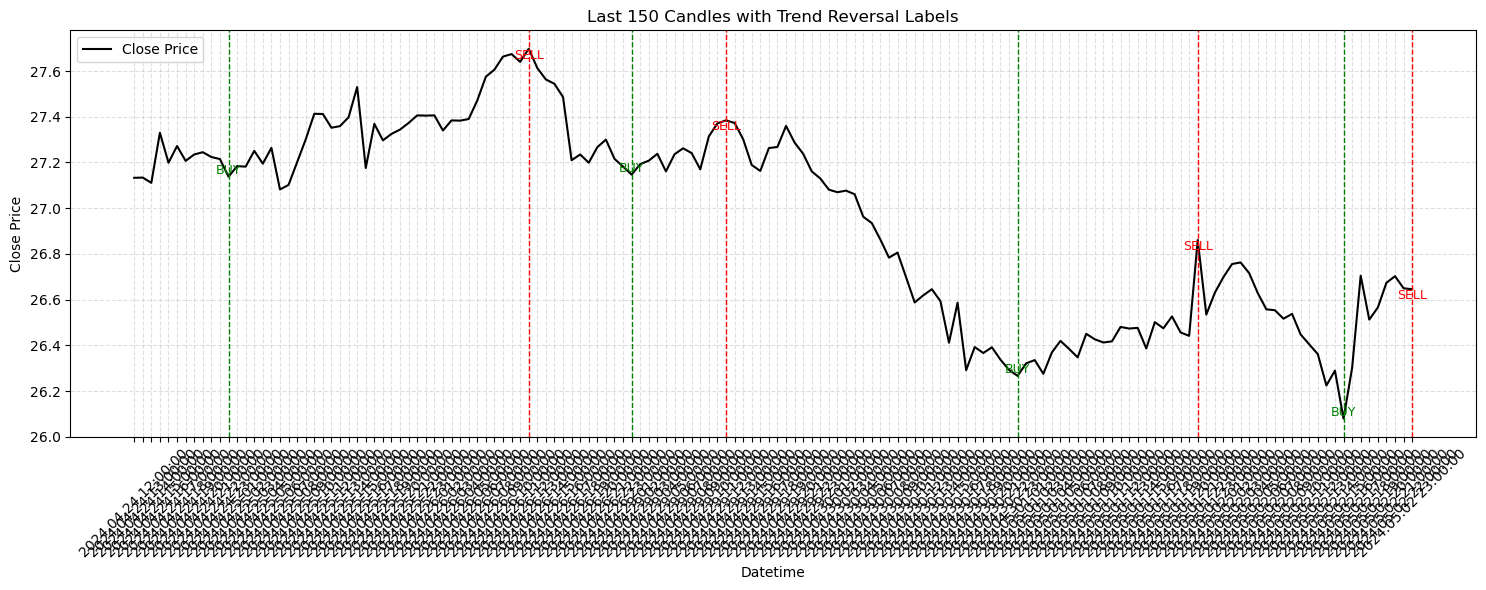

In [6]:
plot_labeled_candles(df)

# plot section